In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [8]:
from sklearn.model_selection import train_test_split
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
# import modules & set up logging
import gensim, logging

def train_word_vecs(w2v_train, window_size, vector_size, save_path=''):
    word2vec_model = gensim.models.Word2Vec(w2v_train, size=vector_size, window=window_size, min_count=5, workers=4, batch_words=128)
    word_vectors = word2vec_model.wv
    if save_path != '': word2vec_model.save(save_path)
    del word2vec_model
    return word_vectors

def load_word_vecs(save_path):
    word2vec_model = gensim.models.Word2Vec.load(save_path)
    word_vectors = word2vec_model.wv
    del word2vec_model
    return word_vectors

def load_sequence(train_data, window_size):
    sequences = list()
    length = window_size + 1
    for user_id, items in train_data.items():
        if len(items) < length: continue
        for i in range(length, len(items)):
            # select sequence of tokens
            seq = items[i-length:i]
            i+=2
            # store
            sequences.append(seq)
    print('Total Sequences: %d' % len(sequences))
    return np.array(sequences)

def item_to_vec(word_vectors, seqs, window_size):
    result = list()
    for seq in seqs:
        tmp = list()
        for item in seq:
            if item not in word_vectors.vocab:
                continue
            tmp.append(word_vectors[item])
        if len(tmp) != (window_size+1):
            continue
        result.append(np.array(tmp))
    return np.asarray(result)

def generate_sequences_3D(dict_data, window_size, word_vectors, drop_ratio=0):
    # get sequences
    sequences = load_sequence(dict_data, window_size)
    if drop_ratio>0:
        sequences, sequences_drop = train_test_split(sequences, test_size=drop_ratio, random_state=42)
    sequences = item_to_vec(word_vectors, sequences, window_size)
    X, y = sequences[:,:-1, :], sequences[:, -1, :]
    return X, y

def train_lstm_model_1(X_train, y_train, X_test, y_test, vector_size, n_units):
    np.random.seed(42)
    # design network
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(vector_size))
    model.compile(loss='cosine_proximity', optimizer='adam')
    # fit network
    history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    return history, model

def train_lstm_model_2(X_train, y_train, X_test, y_test, vector_size, n_units):
    np.random.seed(42)
    # design network
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(n_units))
    model.add(Dense(vector_size))
    model.compile(loss='cosine_proximity', optimizer='adam')
    # fit network
    history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    return history, model

def train_lstm_model_3(X_train, y_train, X_test, y_test, vector_size, n_units):
    np.random.seed(42)
    # design network
    model = Sequential()
    model.add(LSTM(1024, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(1024, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(1024))
    model.add(Dense(vector_size))
    model.compile(loss='cosine_proximity', optimizer='adam')
    # fit network
    history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    return history, model

In [3]:
# prepqre data
path = './nlp_validate/birch6/'
train_data = np.load(path + 'user_train_data.npy').item() #train_data[0] = dict(key=id_user, value=list of history)
test_data = np.load(path + 'user_test_data.npy').item()

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARN)

records = dict()
window_size = 5
vector_size = 128
#records[vector_size] = dict()
w2v_train = list()
#for cluster in range(0, 6):
#    w2v_train.extend(list(train_data[cluster].values()))
#word_vectors = train_word_vecs(w2v_train, window_size, vector_size, save_path=path+'w2vmodel_'+str(vector_size))
word_vectors = load_word_vecs(path+'w2vmodel_'+str(vector_size))

In [9]:
#调参
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def item_to_vec_2D(word_vectors, seq, window_size):
    tmp = list()
    for item in seq:
        if item not in word_vectors.vocab:
            return np.array([])
        tmp.append(word_vectors[item])
    return np.asarray(tmp)

def evaluate(N, cluster, model):
    window_size = 5
    hit = 0
    precision = 0.0
    recall = 0.0
    for user_id, itemset in test_data[cluster].items():
        history = train_data[cluster][user_id]
        if len(history)<window_size:continue
        if np.random.random()>0.1: continue
        history = item_to_vec_2D(word_vectors, history[-window_size:], window_size)
        if len(history)==0: continue
        history = history.reshape(1, window_size, vector_size)
        precision += N
        recall += len(itemset)
        pred_vec = model.predict(history)
        pred_set = word_vectors.most_similar(positive=pred_vec, topn=N)
        for pred_item, score in pred_set:
            if pred_item in itemset: 
                hit+=1
    precision = hit/precision
    recall = hit/recall
    return precision, recall

cluster = 0
for n_units in [128]:
    print('units', n_units)
    X_train, y_train = generate_sequences_3D(train_data[cluster], window_size, word_vectors, drop_ratio=0.98)
    X_test, y_test = generate_sequences_3D(test_data[cluster], window_size, word_vectors, drop_ratio=0.98)
    history, model = train_lstm_model_3(X_train, y_train, X_test, y_test, vector_size, n_units)
    precision, recall = evaluate(10, cluster, model)
    del model
    print(precision, recall)

units 128
Total Sequences: 3211196
Total Sequences: 313572
Train on 64183 samples, validate on 6167 samples
Epoch 1/20
 - 934s - loss: -6.8917e-01 - val_loss: -7.3393e-01
Epoch 2/20
 - 864s - loss: -7.1203e-01 - val_loss: -7.3979e-01
Epoch 3/20
 - 852s - loss: -7.1706e-01 - val_loss: -7.4150e-01
Epoch 4/20
 - 928s - loss: -7.2088e-01 - val_loss: -7.4075e-01
Epoch 5/20
 - 994s - loss: -7.2501e-01 - val_loss: -7.3942e-01
Epoch 6/20
 - 914s - loss: -7.3024e-01 - val_loss: -7.3606e-01
Epoch 7/20
 - 977s - loss: -7.3797e-01 - val_loss: -7.3293e-01
Epoch 8/20
 - 1034s - loss: -7.4865e-01 - val_loss: -7.3004e-01
Epoch 9/20
 - 922s - loss: -7.6299e-01 - val_loss: -7.2333e-01
Epoch 10/20
 - 949s - loss: -7.7741e-01 - val_loss: -7.1788e-01
Epoch 11/20
 - 931s - loss: -7.9419e-01 - val_loss: -7.0528e-01
Epoch 12/20
 - 850s - loss: -8.1105e-01 - val_loss: -7.0058e-01
Epoch 13/20
 - 853s - loss: -8.2702e-01 - val_loss: -6.9962e-01
Epoch 14/20
 - 854s - loss: -8.4076e-01 - val_loss: -6.9707e-01
Epoc

In [6]:
#训练模型
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model_name = '64'

for cluster in range(0, 1):
    if cluster == 2: continue
    X_train, y_train = generate_sequences_3D(train_data[cluster], window_size, word_vectors, drop_ratio=0.98)
    X_test, y_test = generate_sequences_3D(test_data[cluster], window_size, word_vectors, drop_ratio=0.98)
    history, model = train_lstm_model_1(X_train, y_train, X_test, y_test, vector_size)
    model.save(path+'model0_'+model_name+'.h5')
    del model
    #records[cluster] = history

#results = dict()
#for k, v in records.items():
#    results[k] = dict()
#    results[k]['loss'] = v.history['loss']
#    results[k]['val_loss'] = v.history['val_loss']
#np.save(path + 'lstm_arols_final.npy', results)

Total Sequences: 3211196
Total Sequences: 313572
Train on 64183 samples, validate on 6167 samples
Epoch 1/20
 - 11s - loss: -6.4999e-01 - val_loss: -7.1452e-01
Epoch 2/20
 - 11s - loss: -6.9978e-01 - val_loss: -7.2861e-01
Epoch 3/20
 - 10s - loss: -7.0679e-01 - val_loss: -7.3388e-01
Epoch 4/20
 - 11s - loss: -7.1008e-01 - val_loss: -7.3657e-01
Epoch 5/20
 - 10s - loss: -7.1209e-01 - val_loss: -7.3822e-01
Epoch 6/20
 - 10s - loss: -7.1351e-01 - val_loss: -7.3937e-01
Epoch 7/20
 - 11s - loss: -7.1460e-01 - val_loss: -7.4024e-01
Epoch 8/20
 - 11s - loss: -7.1548e-01 - val_loss: -7.4092e-01
Epoch 9/20
 - 11s - loss: -7.1621e-01 - val_loss: -7.4144e-01
Epoch 10/20
 - 11s - loss: -7.1682e-01 - val_loss: -7.4186e-01
Epoch 11/20
 - 10s - loss: -7.1733e-01 - val_loss: -7.4218e-01
Epoch 12/20
 - 10s - loss: -7.1777e-01 - val_loss: -7.4244e-01
Epoch 13/20
 - 10s - loss: -7.1816e-01 - val_loss: -7.4265e-01
Epoch 14/20
 - 11s - loss: -7.1849e-01 - val_loss: -7.4283e-01
Epoch 15/20
 - 10s - loss: -7

In [25]:
# 准确率，覆盖率测试
from keras.models import load_model
import pandas as pd

def item_to_vec_2D(word_vectors, seq, window_size):
    tmp = list()
    for item in seq:
        if item not in word_vectors.vocab:
            return np.array([])
        tmp.append(word_vectors[item])
    return np.asarray(tmp)

cluster = 0
window_size = 5

model = model = load_model(path+'model0_'+model_name+'.h5')

results = pd.DataFrame(columns=['N', 'precision', 'recall', 'f1score'])

for N in range(5, 65, 5):
    hit = 0
    precision = 0.0
    recall = 0.0
    for user_id, itemset in test_data[cluster].items():
        history = train_data[cluster][user_id]
        if len(history)<window_size:continue
        if np.random.random()>0.1: continue
        history = item_to_vec_2D(word_vectors, history[-window_size:], window_size)
        if len(history)==0: continue
        history = history.reshape(1, window_size, vector_size)
        precision += N
        recall += len(itemset)
        pred_vec = model.predict(history)
        pred_set = word_vectors.most_similar(positive=pred_vec, topn=N)
        for pred_item, score in pred_set:
            if pred_item in itemset: 
                hit+=1
    precision = hit/precision
    recall = hit/recall
    results.loc[len(results)] = [N, precision, recall, 2*recall*precision/(recall+precision)]
    print(precision, recall)
results.to_csv(path + 'lstm_arols_N_baseline.csv', index=False)

0.1492896174863388 0.018875746186159628
0.134037558685446 0.031660659828112
0.12474389282899921 0.04378734233237442
0.12275784753363228 0.05885672821091671
0.11219730941704036 0.06882513135092014
0.11441947565543072 0.08475281584641847
0.10516643550624133 0.08399800598205384
0.1072480181200453 0.09993931878743108
0.10183852917665867 0.10873709067114284
0.10410958904109589 0.12863187588152328
0.09670096531240055 0.12947392341779343
0.10116497557309283 0.1429329935223532


In [8]:
#测试lstm层数
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

for cluster in range(0, 1):
    if cluster == 2: continue
    records[cluster] = dict()
    X_train, y_train = generate_sequences_3D(train_data[cluster], window_size, word_vectors, drop_ratio=0.99)
    X_test, y_test = generate_sequences_3D(test_data[cluster], window_size, word_vectors, drop_ratio=0.99)
    history, model = train_lstm_model_1(X_train, y_train, X_test, y_test, vector_size)
    del model
    records[cluster][1] = history
    history, model = train_lstm_model_2(X_train, y_train, X_test, y_test, vector_size)
    del model
    records[cluster][2] = history
    history, model = train_lstm_model_3(X_train, y_train, X_test, y_test, vector_size)
    del model
    records[cluster][3] = history

results = dict()
for cluster in range(0, 1):
    if cluster == 2: continue
    results[cluster] = dict()
    for k, v in records[cluster].items():
        results[cluster][k] = dict()
        results[cluster][k]['loss'] = v.history['loss']
        results[cluster][k]['val_loss'] = v.history['val_loss']
np.save(path + 'lstm_word2vec_n_layers_256_256128_256128256.npy', results)

Total Sequences: 3211196
Total Sequences: 313572
Train on 32091 samples, validate on 3083 samples
Epoch 1/20
 - 12s - loss: -6.7101e-01 - val_loss: -7.3103e-01
Epoch 2/20
 - 10s - loss: -7.0871e-01 - val_loss: -7.3802e-01
Epoch 3/20
 - 10s - loss: -7.1383e-01 - val_loss: -7.4123e-01
Epoch 4/20
 - 10s - loss: -7.1679e-01 - val_loss: -7.4294e-01
Epoch 5/20
 - 10s - loss: -7.1897e-01 - val_loss: -7.4397e-01
Epoch 6/20
 - 10s - loss: -7.2075e-01 - val_loss: -7.4455e-01
Epoch 7/20
 - 10s - loss: -7.2232e-01 - val_loss: -7.4481e-01
Epoch 8/20
 - 10s - loss: -7.2378e-01 - val_loss: -7.4481e-01
Epoch 9/20
 - 13s - loss: -7.2519e-01 - val_loss: -7.4462e-01
Epoch 10/20
 - 12s - loss: -7.2660e-01 - val_loss: -7.4432e-01
Epoch 11/20
 - 11s - loss: -7.2803e-01 - val_loss: -7.4392e-01
Epoch 12/20
 - 12s - loss: -7.2951e-01 - val_loss: -7.4341e-01
Epoch 13/20
 - 11s - loss: -7.3107e-01 - val_loss: -7.4276e-01
Epoch 14/20
 - 12s - loss: -7.3273e-01 - val_loss: -7.4191e-01
Epoch 15/20
 - 12s - loss: -7

In [16]:
#测试units个数
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

for cluster in range(0, 6):
    if cluster == 2: continue
    records[cluster] = dict()
    X_train, y_train = generate_sequences_3D(train_data[cluster], window_size, word_vectors, drop_ratio=0.99)
    X_test, y_test = generate_sequences_3D(test_data[cluster], window_size, word_vectors, drop_ratio=0.99)
    for n_units in [64, 128, 256]:
        history, model = train_lstm_model_1(X_train, y_train, X_test, y_test, vector_size, n_units)
        del model
        records[cluster][n_units] = history

results = dict()
for cluster in range(0, 6):
    if cluster == 2: continue
    results[cluster] = dict()
    for k, v in records[cluster].items():
        results[cluster][k] = dict()
        results[cluster][k]['loss'] = v.history['loss']
        results[cluster][k]['val_loss'] = v.history['val_loss']
np.save(path + 'lstm_word2vec_units.npy', results)

Total Sequences: 3211196
Total Sequences: 313572
Train on 32091 samples, validate on 3083 samples
Epoch 1/20
 - 164s - loss: -6.8552e-01 - val_loss: -7.2831e-01
Epoch 2/20
 - 162s - loss: -7.0518e-01 - val_loss: -7.3323e-01
Epoch 3/20
 - 162s - loss: -7.0898e-01 - val_loss: -7.3500e-01
Epoch 4/20
 - 164s - loss: -7.1119e-01 - val_loss: -7.3567e-01
Epoch 5/20
 - 164s - loss: -7.1278e-01 - val_loss: -7.3592e-01
Epoch 6/20
 - 164s - loss: -7.1402e-01 - val_loss: -7.3601e-01
Epoch 7/20
 - 166s - loss: -7.1503e-01 - val_loss: -7.3583e-01
Epoch 8/20
 - 167s - loss: -7.1590e-01 - val_loss: -7.3555e-01
Epoch 9/20
 - 167s - loss: -7.1667e-01 - val_loss: -7.3538e-01
Epoch 10/20
 - 164s - loss: -7.1738e-01 - val_loss: -7.3493e-01
Epoch 11/20
 - 163s - loss: -7.1806e-01 - val_loss: -7.3447e-01
Epoch 12/20
 - 163s - loss: -7.1869e-01 - val_loss: -7.3398e-01
Epoch 13/20
 - 165s - loss: -7.1928e-01 - val_loss: -7.3350e-01
Epoch 14/20
 - 166s - loss: -7.1984e-01 - val_loss: -7.3320e-01
Epoch 15/20
 - 

Epoch 4/20
 - 64s - loss: -7.8899e-01 - val_loss: -7.9494e-01
Epoch 5/20
 - 63s - loss: -7.9122e-01 - val_loss: -7.9500e-01
Epoch 6/20
 - 63s - loss: -7.9299e-01 - val_loss: -7.9498e-01
Epoch 7/20
 - 65s - loss: -7.9447e-01 - val_loss: -7.9484e-01
Epoch 8/20
 - 64s - loss: -7.9579e-01 - val_loss: -7.9437e-01
Epoch 9/20
 - 63s - loss: -7.9697e-01 - val_loss: -7.9407e-01
Epoch 10/20
 - 64s - loss: -7.9806e-01 - val_loss: -7.9352e-01
Epoch 11/20
 - 64s - loss: -7.9908e-01 - val_loss: -7.9296e-01
Epoch 12/20
 - 60s - loss: -8.0006e-01 - val_loss: -7.9238e-01
Epoch 13/20
 - 63s - loss: -8.0099e-01 - val_loss: -7.9175e-01
Epoch 14/20
 - 65s - loss: -8.0186e-01 - val_loss: -7.9108e-01
Epoch 15/20
 - 66s - loss: -8.0270e-01 - val_loss: -7.9044e-01
Epoch 16/20
 - 64s - loss: -8.0350e-01 - val_loss: -7.8985e-01
Epoch 17/20
 - 64s - loss: -8.0427e-01 - val_loss: -7.8920e-01
Epoch 18/20
 - 64s - loss: -8.0502e-01 - val_loss: -7.8879e-01
Epoch 19/20
 - 63s - loss: -8.0576e-01 - val_loss: -7.8811e-0

Epoch 9/20
 - 37s - loss: -7.3435e-01 - val_loss: -7.2407e-01
Epoch 10/20
 - 37s - loss: -7.3642e-01 - val_loss: -7.2338e-01
Epoch 11/20
 - 37s - loss: -7.3835e-01 - val_loss: -7.2232e-01
Epoch 12/20
 - 37s - loss: -7.4018e-01 - val_loss: -7.2136e-01
Epoch 13/20
 - 37s - loss: -7.4197e-01 - val_loss: -7.2031e-01
Epoch 14/20
 - 37s - loss: -7.4372e-01 - val_loss: -7.1907e-01
Epoch 15/20
 - 37s - loss: -7.4545e-01 - val_loss: -7.1776e-01
Epoch 16/20
 - 38s - loss: -7.4717e-01 - val_loss: -7.1644e-01
Epoch 17/20
 - 38s - loss: -7.4884e-01 - val_loss: -7.1502e-01
Epoch 18/20
 - 38s - loss: -7.5048e-01 - val_loss: -7.1370e-01
Epoch 19/20
 - 37s - loss: -7.5215e-01 - val_loss: -7.1233e-01
Epoch 20/20
 - 39s - loss: -7.5370e-01 - val_loss: -7.1123e-01
Train on 7580 samples, validate on 704 samples
Epoch 1/20
 - 44s - loss: -6.8199e-01 - val_loss: -7.1740e-01
Epoch 2/20
 - 42s - loss: -7.1407e-01 - val_loss: -7.2539e-01
Epoch 3/20
 - 40s - loss: -7.2220e-01 - val_loss: -7.2758e-01
Epoch 4/20
 

In [28]:
#测试vector_size
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

for cluster in range(0, 6):
    if cluster == 2: continue
    X_train, y_train = generate_sequences_3D(train_data[cluster], window_size, word_vectors, drop_ratio=0.99)
    X_test, y_test = generate_sequences_3D(test_data[cluster], window_size, word_vectors, drop_ratio=0.99)
    history, model = train_lstm_model(X_train, y_train, X_test, y_test, vector_size)
    del model
    records[vector_size][cluster] = history

results = dict()
for k, v in records[vector_size].items():
    results[k] = dict()
    results[k]['loss'] = v.history['loss']
    results[k]['val_loss'] = v.history['val_loss']
np.save(path + 'lstm_word2vec_dim_'+str(vector_size)+'.npy', results)

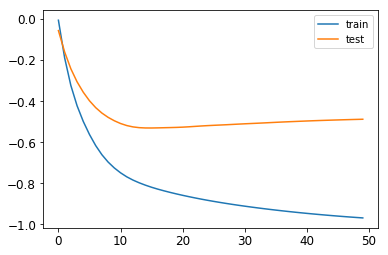

In [157]:
# plot history
plt.plot(records[128][3].history['loss'], label='train')
plt.plot(records[128][3].history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
test_in = X_test[0]
test_in = test_in.reshape(1, 2, 4)

In [13]:
test_pred = model.predict(test_in)

In [14]:
word_vectors.most_similar(positive=test_pred, topn=10)

2018-01-10 15:37:10,418 : INFO : precomputing L2-norms of word weight vectors


[('the', 0.7194439768791199),
 ('To', 0.693936288356781),
 ('broke', 0.6766509413719177),
 ('of', 0.5830400586128235),
 ('And', 0.48103225231170654),
 ('a', 0.32743772864341736),
 ('up', 0.1653699278831482),
 ('and', 0.1354544460773468),
 ('tumbling', 0.06964272260665894),
 ('down', 0.06605370342731476)]

In [23]:
#准确率测试

# 准确率，覆盖率测试
from keras.models import load_model

def generate_sequences_3D_eval(dict_data, window_size, word_vectors, drop_ratio=0):
    # get sequences
    sequences = load_sequence(dict_data, window_size)
    if drop_ratio>0:
        sequences, sequences_drop = train_test_split(sequences, test_size=drop_ratio, random_state=42)
    X, y = sequences[:,:-1], sequences[:, -1]
    X = item_to_vec(word_vectors, X, window_size-1)
    return X, y

cluster = 0
window_size = 5

model = model = load_model(path+'model_'+str(cluster)+'.h5')

hit = 0
precision = 0.0

X_test, y_test = generate_sequences_3D_eval(test_data[cluster], window_size, word_vectors, drop_ratio=0.99)
precision = len(y_test)

for i in range(0, len(X_test)):
    pred_vec = model.predict(X_test[i].reshape(1, window_size, vector_size))
    pred_set = word_vectors.most_similar(positive=pred_vec, topn=1)
    for pred_item, score in pred_set:
        if pred_item == y_test[i]:
            hit += 1

print(hit/precision, hit/recall)

Total Sequences: 313572
0.0006379585326953748 2.8239015023155993e-05
